In [86]:
import numpy as np
from benchmark import DataFrame
import matplotlib.pyplot as plt
datas = DataFrame("./res.json")
all_task_names = datas.find_all_task()
all_params = datas.find_all_params()
print("All tasks: ", all_task_names)
print("All parameters: ", all_params)

All tasks:  ['random_circuit_evolution', 'random_ham_expectation', '4_regular_maxcut']
All parameters:  ['framework', 'platform', 'n_qubit']


In [87]:
all_platforms = datas.find_all_keys('platform')
all_frameworks = datas.find_all_keys('framework')
print("All platform: ", all_platforms)
print("All framework: ", all_frameworks)

All platform:  ['cpu', 'gpu']
All framework:  ['intel', 'mindquantum', 'paddle_quantum', 'quest', 'qulacs', 'tensorflow_quantum', 'qiskit', 'qpanda', 'mindquantum_opt']


In [88]:
fw_color_map = {
    'intel': '#293462',
    'mindquantum': 'k',
    'paddle_quantum': '#a64942',
    'quest': '#e59572',
    'qulacs': '#515bd4',
    'tensorcircuit': '#8134af',
    'tensorflow_quantum': '#dd2a7b',
    'qiskit': '#feda77',
    'qpanda': '#9dd3a8',
    'mindquantum_cpp': 'r',
    'mindquantum_opt': 'y'
}
task_color_map = {
    'random_circuit_evolution': '#de4307',
    'random_ham_expectation': '#f6d04d',
    '4_regular_maxcut': '#8bc24c',
}

class SelectColor:
    def __init__(self):
        self.map1=fw_color_map
        self.map2=task_color_map
        self.c=list(range(10)) + [chr(i) for i in range(ord('a'), ord('f')+1)]
    def __getitem__(self, w):
        if w in self.map1:
            return self.map1[w]
        if w in self.map2:
            return self.map2[w]        
        return self.random_color()
    def random_color(self):
        return '#'+''.join(np.random.choice(self.c, 6))
# framework_filter = ['tensorcircuit', 'qpanda', 'paddle_quantum']
framework_filter = []
select_color = SelectColor()

In [89]:
def plot_benchmark(task_name, platform):
    framework_tasks = datas.filter_task(task_name).filter_task_params('platform', platform).split_by_params('framework')
    plt.subplots(dpi=180, figsize=(8, 4))
    x_max, x_min = -np.inf, np.inf
    for f in framework_tasks:
        x, y = f.extra_x_time('n_qubit', np.mean)
        framework_name = f.find_all_keys('framework')[0]
        if framework_name in framework_filter:
            continue
        lw=1
        if framework_name == 'mindquantum':
            lw=2
        plt.plot(x,
                 y,
                 '-',
                 label=framework_name,
                 zorder=-1,
                 c=select_color[framework_name],lw=lw)
        plt.scatter(x,
                    y,
                    s=15,
                    facecolors='w',
                    edgecolors=select_color[framework_name],
                    zorder=2)
        x_max = max(x_max, max(x))
        x_min = min(x_min, min(x))
    plt.xticks(range(x_min, x_max + 1))
    plt.legend(prop={"size": 8}, ncol=2)
    plt.yscale('log')
    plt.title(f"{task_name}({platform})")

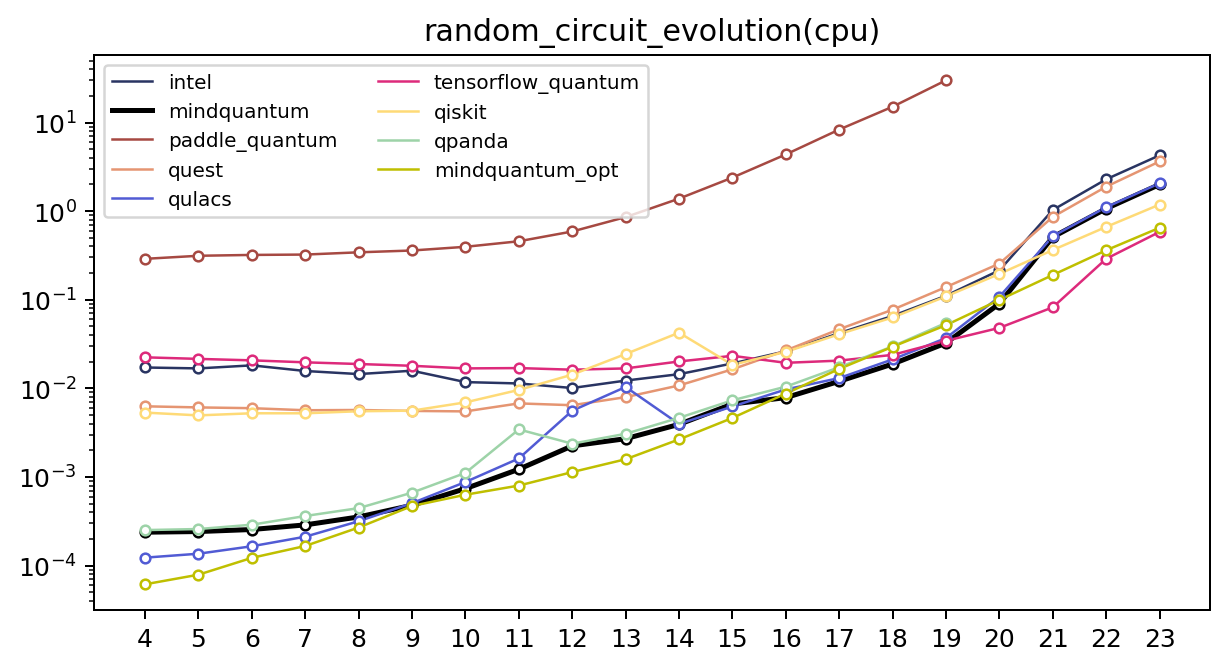

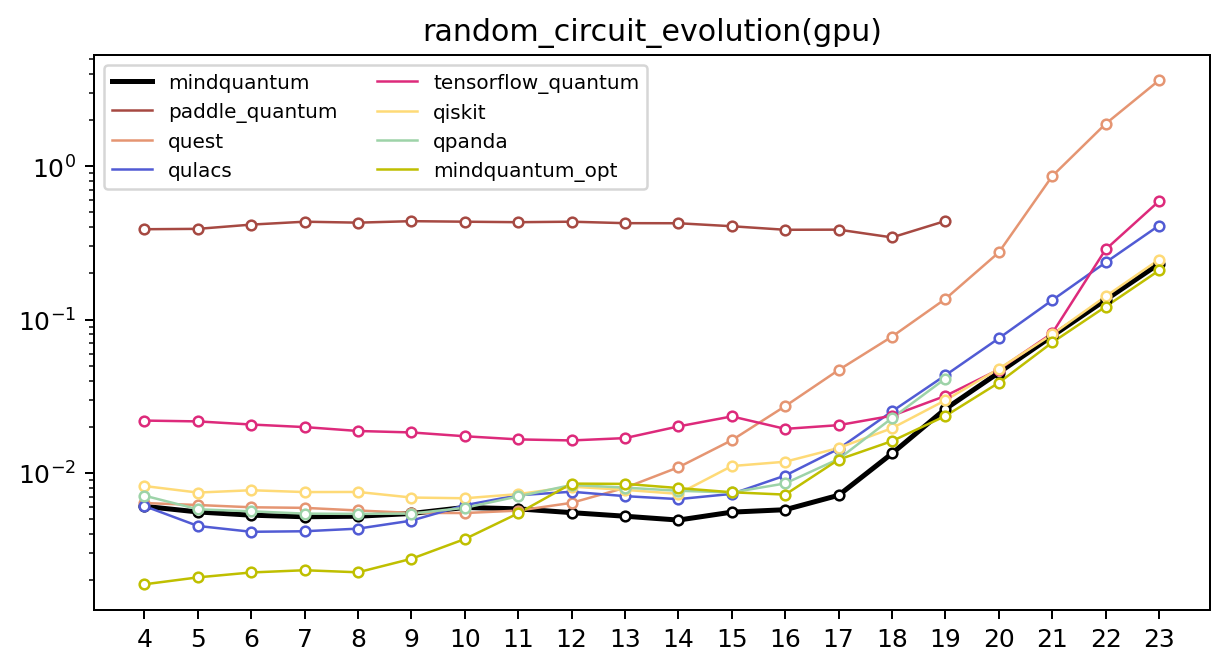

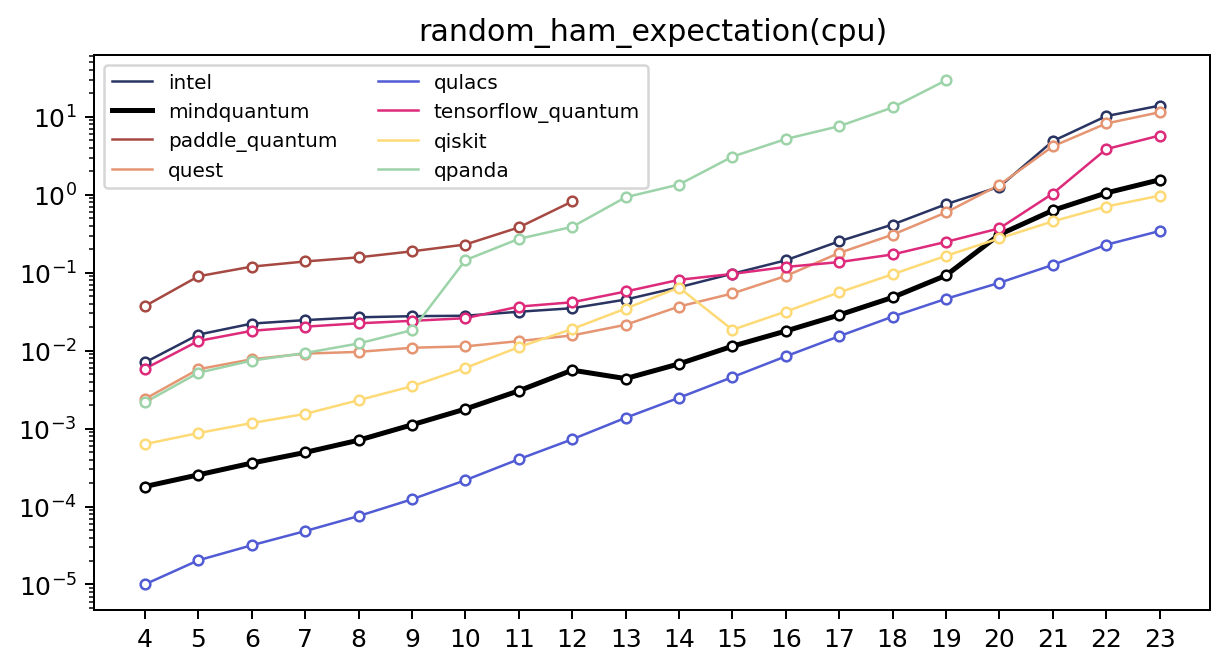

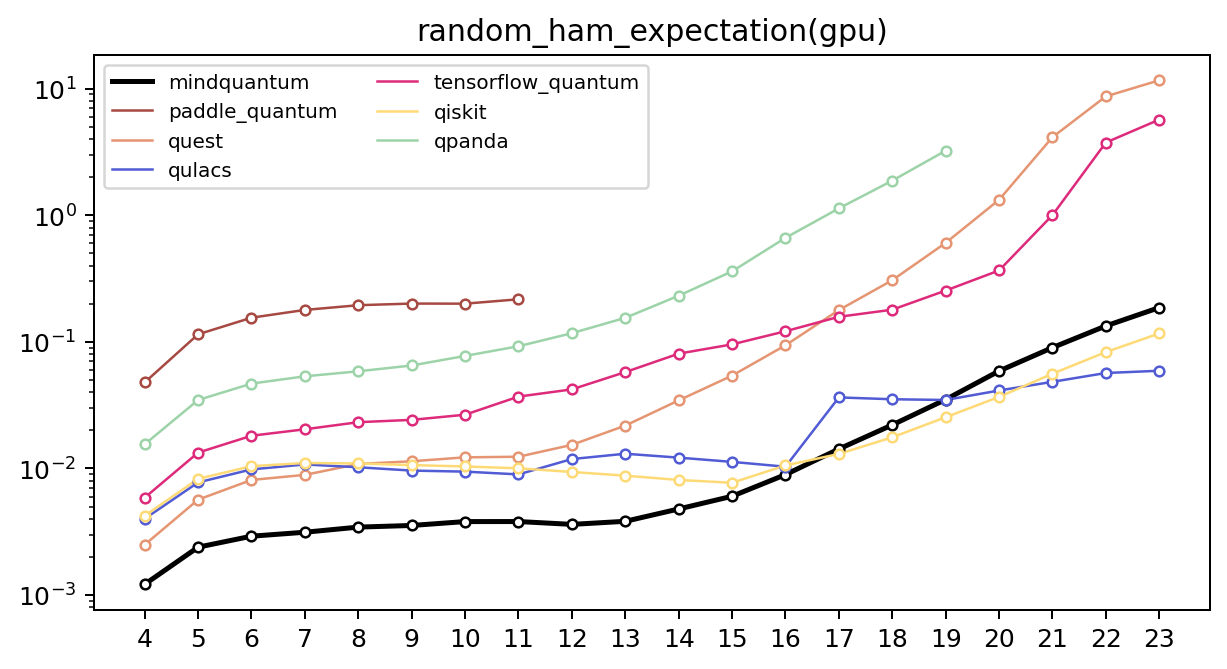

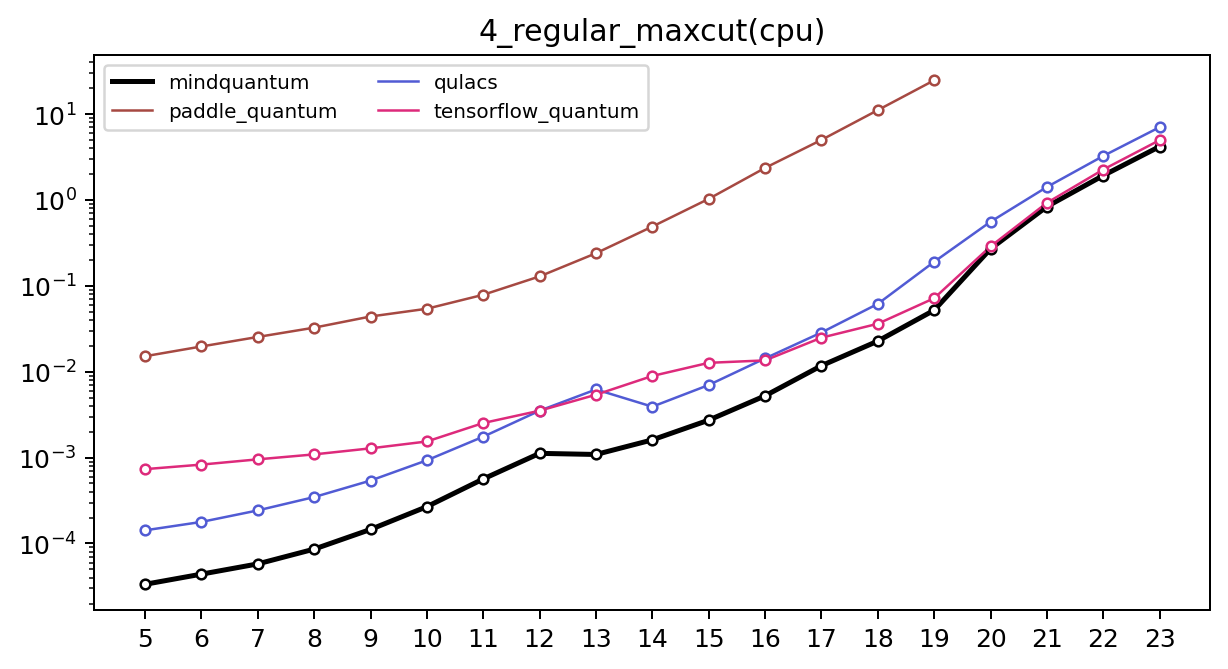

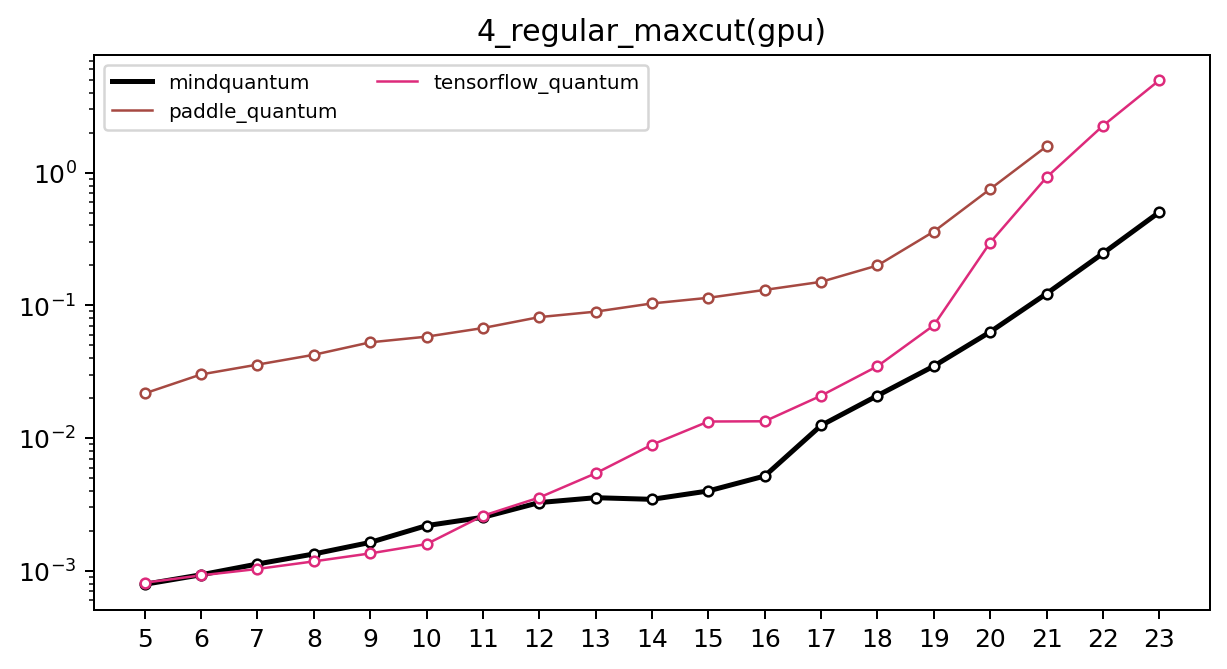

In [90]:
for task_name in all_task_names:
    for platform in all_platforms:
        plot_benchmark(task_name, platform)

In [91]:
print("All tasks: ", all_task_names)
print("All parameters: ", all_params)
print("All platform: ", all_platforms)
print("All framework: ", all_frameworks)

All tasks:  ['random_circuit_evolution', 'random_ham_expectation', '4_regular_maxcut']
All parameters:  ['framework', 'platform', 'n_qubit']
All platform:  ['cpu', 'gpu']
All framework:  ['intel', 'mindquantum', 'paddle_quantum', 'quest', 'qulacs', 'tensorflow_quantum', 'qiskit', 'qpanda', 'mindquantum_opt']


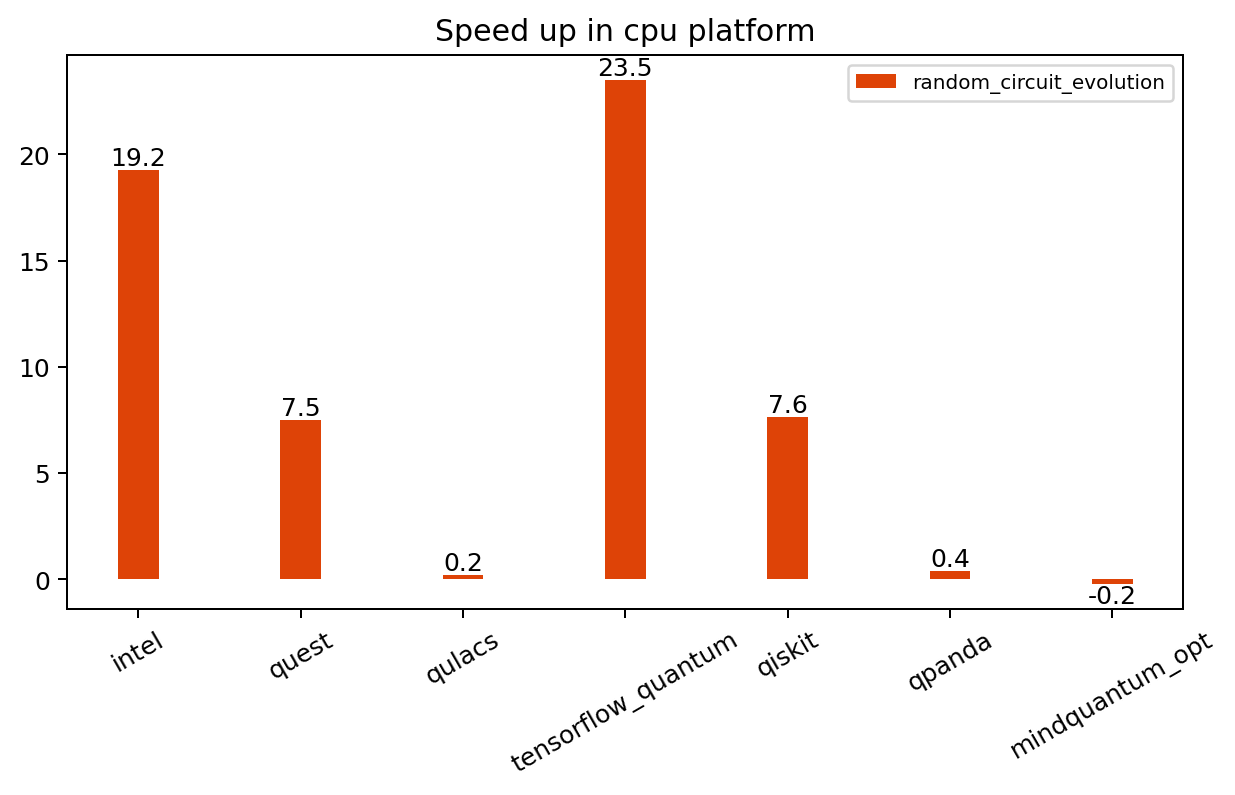

In [100]:
base='mindquantum'
def plot_speedup(platform, datas):
    datas = datas.filter_task('random_circuit_evolution')
    framework_filter = ['paddle_quantum']
    x_frameworks = datas.filter_task_params('platform', platform).find_all_keys('framework')
    x_frameworks.remove(base)
    for x in framework_filter:
        x_frameworks.remove(x)
    x_task_names = datas.filter_task_params('platform', platform).find_all_task()
    x = np.arange(len(x_frameworks))
    bar_width = 0.25
    relative_x = np.arange(len(x_task_names))*bar_width-(len(x_task_names)-1)/2*bar_width
    plt.subplots(dpi=180, figsize=(8, 4))

    for task_id, task_name in enumerate(x_task_names):
        rest_tasks = datas.filter_task(task_name).filter_task_params('platform',platform)
        mq_tasks = rest_tasks.filter_task_params('framework',base)
        mq_n_qubit, mq_time = mq_tasks.extra_x_time('n_qubit', np.mean)
        res_fws = []
        speedups = []
        for framework in rest_tasks.find_all_keys('framework'):
            if framework in framework_filter:
                continue
            if framework != base:
                other_task = rest_tasks.filter_task_params('framework',framework)
                other_n_qubit, other_time = other_task.extra_x_time(
                    'n_qubit', np.mean)
                speedup = []
                for qid in sorted(list(set(other_n_qubit).intersection(set(mq_n_qubit)))):
#                     if qid<18:
#                         continue
                    speedup.append(other_time[other_n_qubit.index(qid)] /
                                mq_time[mq_n_qubit.index(qid)] - 1)
                speedup = np.mean(speedup)
                res_fws.append(framework)
                speedups.append(speedup)
        res_x = [x_frameworks.index(framework) + relative_x[task_id] for framework in res_fws]
        plt.bar_label(plt.bar(res_x,
                              speedups,
                              bar_width,
                              label=task_name,
                              facecolor=select_color[task_name]),
                      fmt='%.1f')
    plt.xticks(x, x_frameworks, rotation=30)
    plt.legend(loc=1, prop={"size": 8})
    plt.title(f"Speed up in {platform} platform")
plot_speedup('cpu', datas)

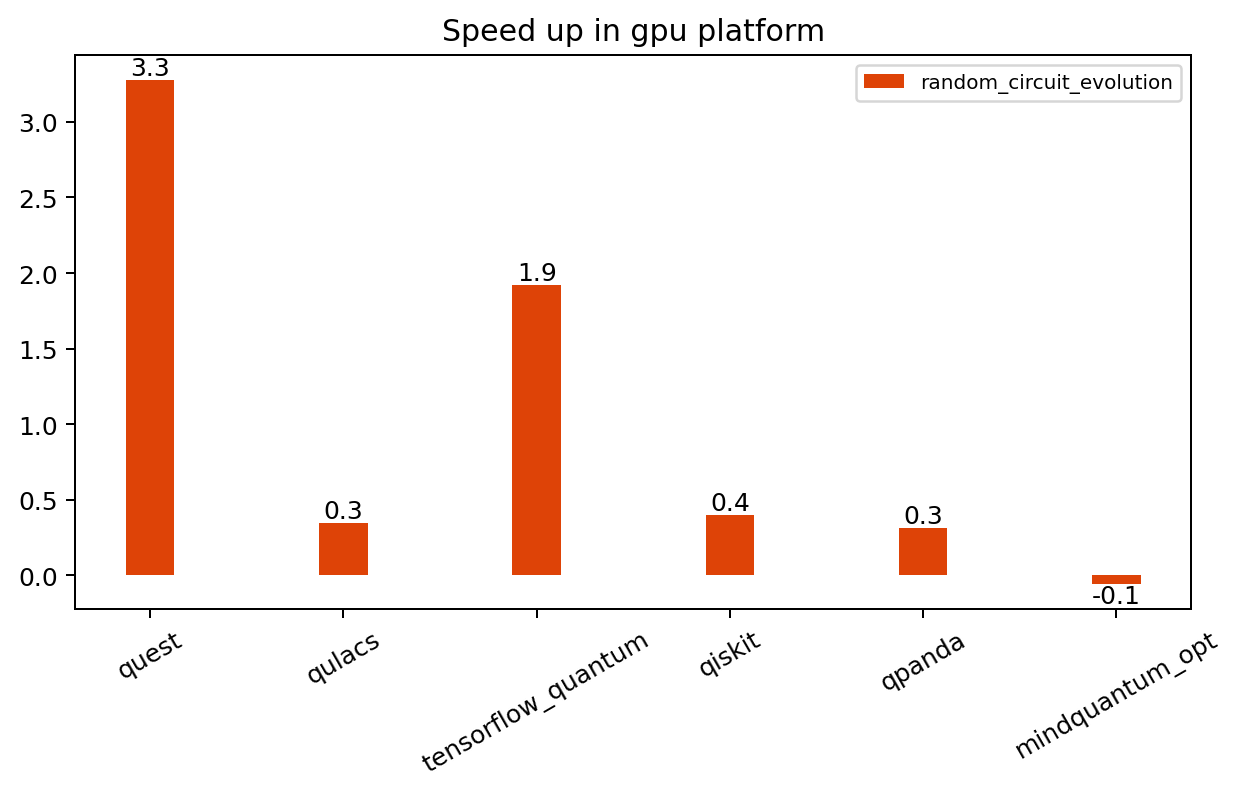

In [101]:
plot_speedup('gpu', datas)